## Define file path

In [1]:
fpath = '/Users/yungkuo/Google Drive/HFSP internal sharing space/Data/spiking HEK cell data/' # path of folder
fname = 'dual berst 9BZn' # file name of fluorescence movie without .tif

In [2]:
framerate = 31.221 #Hz, camera framerate

## Import functions

In [3]:
%matplotlib inline
import numpy as np 
import matplotlib.pyplot as plt
import tifffile as tff
from neo import io
import ROI
import scipy.ndimage as ndi
import matplotlib
from IPython.display import display

In [4]:
#from sys import platform
#if platform == 'darwin':
#    %config InlineBackend.figure_format = 'retina'

## Import movie

In [5]:
tiffimg = tff.TiffFile(fpath+fname+'.tif')
movie = tiffimg.asarray()
print('movie size = {}'.format(movie.shape))

movie size = (4086, 512, 512)


### Exam intensity as function of time 

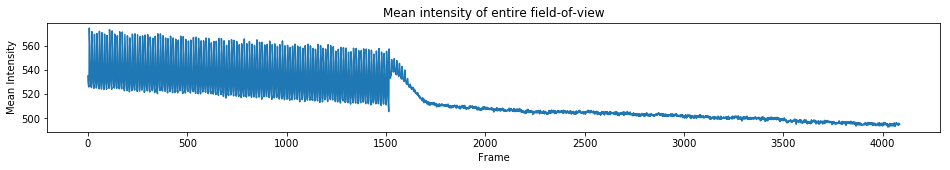

In [6]:
plt.figure(figsize=(16,2))
plt.plot(movie.mean(1).mean(1))
plt.title('Mean intensity of entire field-of-view')
plt.ylabel('Mean Intensity')
plt.xlabel('Frame')

### Plot mean fluorescence image

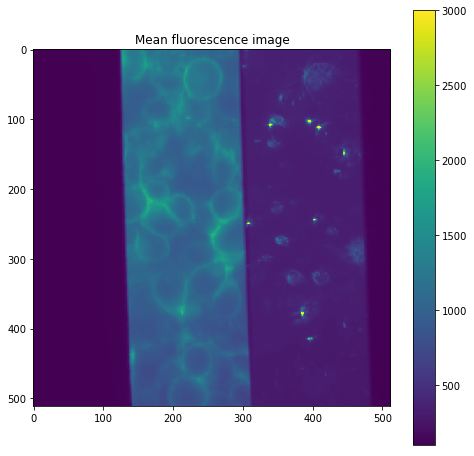

In [7]:
plt.figure(figsize=(8,8))
plt.imshow(movie.mean(0), cmap='viridis', vmax=3000, interpolation='none')
plt.colorbar()
plt.title('Mean fluorescence image')

### Define BeRST and NR regions

In [8]:
berst = (slice(None),slice(0,512),slice(145,295))
NR = (slice(None),slice(0,512),slice(320,430))

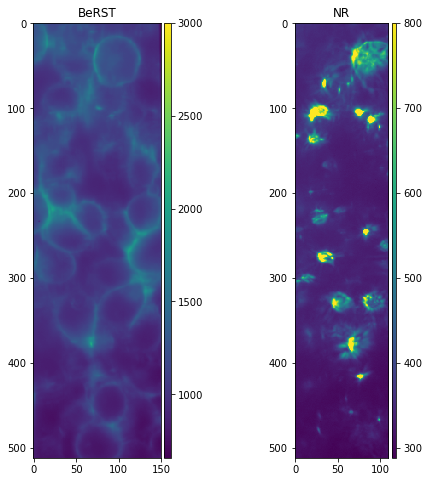

In [9]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
im = {}
fig, ax = plt.subplots(1,2, figsize=(8,8))
im['0'] = ax[0].imshow(movie[berst].mean(0), cmap='viridis', vmax=3000, interpolation='none')
im['1'] = ax[1].imshow(movie[NR].mean(0), cmap='viridis', vmax=800, interpolation='none')

for i in range(2):
    divider = make_axes_locatable(ax[i])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im[str(i)], cax=cax)
ax[0].set_title('BeRST')
ax[1].set_title('NR')

### Plot mean intensity of entire BeRST or NR's field of view

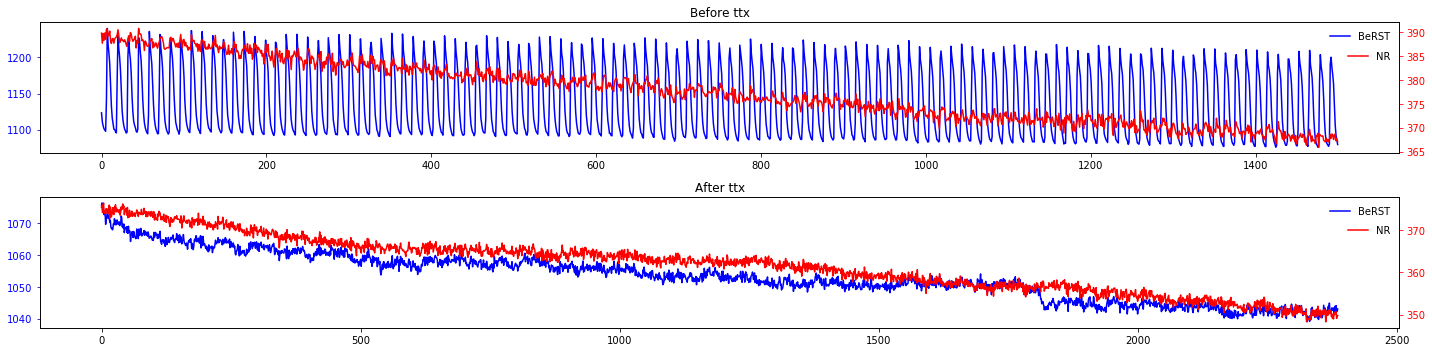

In [10]:
fig, ax = plt.subplots(2,figsize=(20,5))
ax[0].plot(movie[berst].mean(1).mean(1)[:1500],'b', label='BeRST')
axt0 = ax[0].twinx()
axt0.plot(movie[NR].mean(1).mean(1)[:1500], 'r', label='NR')

ax[1].plot(movie[berst].mean(1).mean(1)[1700:],'b', label='BeRST')
axt1 = ax[1].twinx()
axt1.plot(movie[NR].mean(1).mean(1)[1700:], 'r', label='NR')


ax[0].set_title('Before ttx')
ax[1].set_title('After ttx')
for i, (ax, color) in enumerate(zip([ax[0],axt0,ax[1],axt1], ['b','r','b','r'])):
    ax.legend(bbox_to_anchor=(1,1-0.15*(i%2)), frameon=False)
    ax.yaxis.label.set_color(color)
    ax.tick_params(axis='y', colors=color)
fig.tight_layout()
plt.close(fig)
display(fig)

### Plot FFT of traces shown above befroe and after adding ttx

In [11]:
def get_fft(tt, framerate):
    sp = np.fft.fft(tt)
    freq = np.fft.fftfreq(tt.size, d=1./framerate)
    real_half = np.abs(sp.real)[:len(freq)//2]
    return freq[:len(freq)//2], real_half

In [12]:
def get_rfft(tt, framerate):
    sp = np.fft.rfft(tt)
    freq = np.fft.rfftfreq(tt.size, d=1./framerate)
    real = np.abs(sp.real)
    return freq, real

In [13]:
def get_rfft_wMirrorExt(tt, framerate, plot=False):
    tt2 = np.append(tt, tt[:0:-1])
    N = tt2.size
    sp = np.fft.rfft(tt2)
    freq = np.fft.rfftfreq(N, d=1./framerate)
    if plot:
        plt.figure()
        plt.plot(freq[1:], np.abs(sp[1:]))
    return freq, np.abs(sp)

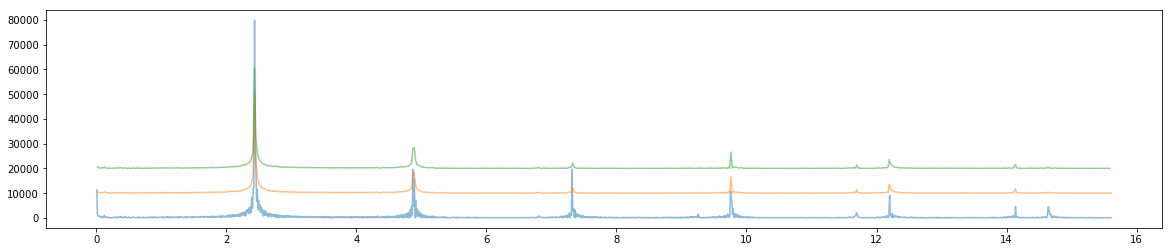

In [14]:
tt = movie[berst].mean(1).mean(1)[:1500]
plt.figure(figsize=(20,4))
plt.plot(get_rfft_wMirrorExt(tt, framerate)[0][1:], 
         get_rfft_wMirrorExt(tt, framerate)[1][1:], alpha=0.5)
plt.plot(get_rfft(tt, framerate)[0][1:], 
         get_rfft(tt, framerate)[1][1:]+10000, alpha=0.5)
plt.plot(get_fft(tt, framerate)[0][1:], 
         get_fft(tt, framerate)[1][1:]+20000, alpha=0.5)

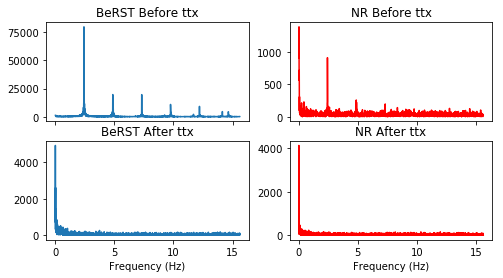

In [15]:
fig, ax = plt.subplots(2,2, figsize=(8,4), sharex=True)
ax[0,0].plot(get_rfft_wMirrorExt(movie[berst].mean(1).mean(1)[:1500], framerate)[0][2:], 
             get_rfft_wMirrorExt(movie[berst].mean(1).mean(1)[:1500], framerate)[1][2:])
ax[0,1].plot(get_rfft_wMirrorExt(movie[NR].mean(1).mean(1)[:1500], framerate)[0][2:], 
             get_rfft_wMirrorExt(movie[NR].mean(1).mean(1)[:1500], framerate)[1][2:], 'r')

ax[1,0].plot(get_rfft_wMirrorExt(movie[berst].mean(1).mean(1)[1700:], framerate)[0][2:], 
             get_rfft_wMirrorExt(movie[berst].mean(1).mean(1)[1700:], framerate)[1][2:])
ax[1,1].plot(get_rfft_wMirrorExt(movie[NR].mean(1).mean(1)[1700:], framerate)[0][2:], 
             get_rfft_wMirrorExt(movie[NR].mean(1).mean(1)[1700:], framerate)[1][2:], 'r')

ax[1,1].set_xlabel('Frequency (Hz)')
ax[1,0].set_xlabel('Frequency (Hz)')

ax[0,1].set_title('NR Before ttx')
ax[0,0].set_title('BeRST Before ttx')
ax[1,1].set_title('NR After ttx')
ax[1,0].set_title('BeRST After ttx')

## Find particles

In [16]:
scan = [4,4]
pts = ROI.finddot(movie[NR].mean(0), scan, nstd=1.3)

In [17]:
pts = np.array([[  41.,   25.],
                [  80.,   70.],
                [  62.,   71.],
                [  51.,   78.],
                [  89.,   78.],
                [  90.,  164.],
                [  34.,  167.],
                [ 100.,  170.],
                [  33.,  196.],
                [  17.,  198.],
                [  92.,  217.],
                [  49.,  220.],
                [  81.,  227.],
                [  54.,  246.],
                [  59.,  255.],
                [  16.,  426.],
                [ 101.,  439.],
                [  59.,  441.],
                [  64.,  457.],
                [  28.,  462.],
                [  98.,  466.],
                [  73.,  473.],
                [  73.,  477.],
                [  27.,  478.],
                [  90.,  484.],
                [  10.,  495.],])

pts_agg = np.array([[  70.,   35.],
       [  68.,   41.],
       [  34.,   70.],
       [  75.,  104.],
       [  18.,  109.],
       [  87.,  113.],
       [  18.,  138.],
       [  82.,  245.],
       [  29.,  273.],
       [  81.,  323.],
       [  45.,  330.],
       [  83.,  331.],
       [  65.,  379.],
       [  74.,  415.],])

In [18]:
len(pts)

26

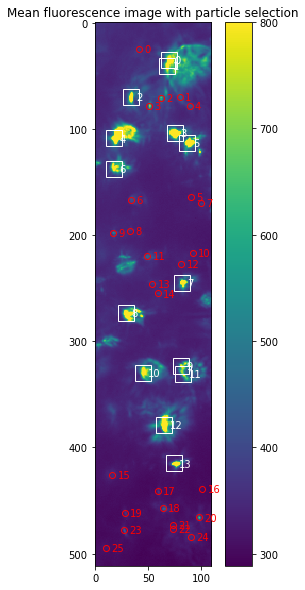

In [19]:
fig, ax = plt.subplots(figsize=(5,10))
ax.plot(pts[:,0], pts[:,1], 'ro', fillstyle='none')
im = ax.imshow(movie[NR].mean(0), cmap='viridis', vmax=800, interpolation='none')
for count, pt in enumerate(pts):
    ax.annotate(count, xy=pt+[5,3], color='r', fontsize=10)

ax.plot(pts_agg[:,0], pts_agg[:,1], 'ws', fillstyle='none', ms=16)
for count, pt in enumerate(pts_agg):
    ax.annotate(count, xy=pt+[5,3], color='w', fontsize=10)    
plt.colorbar(im)
plt.title('Mean fluorescence image with particle selection')

### Plot ROI as function of time

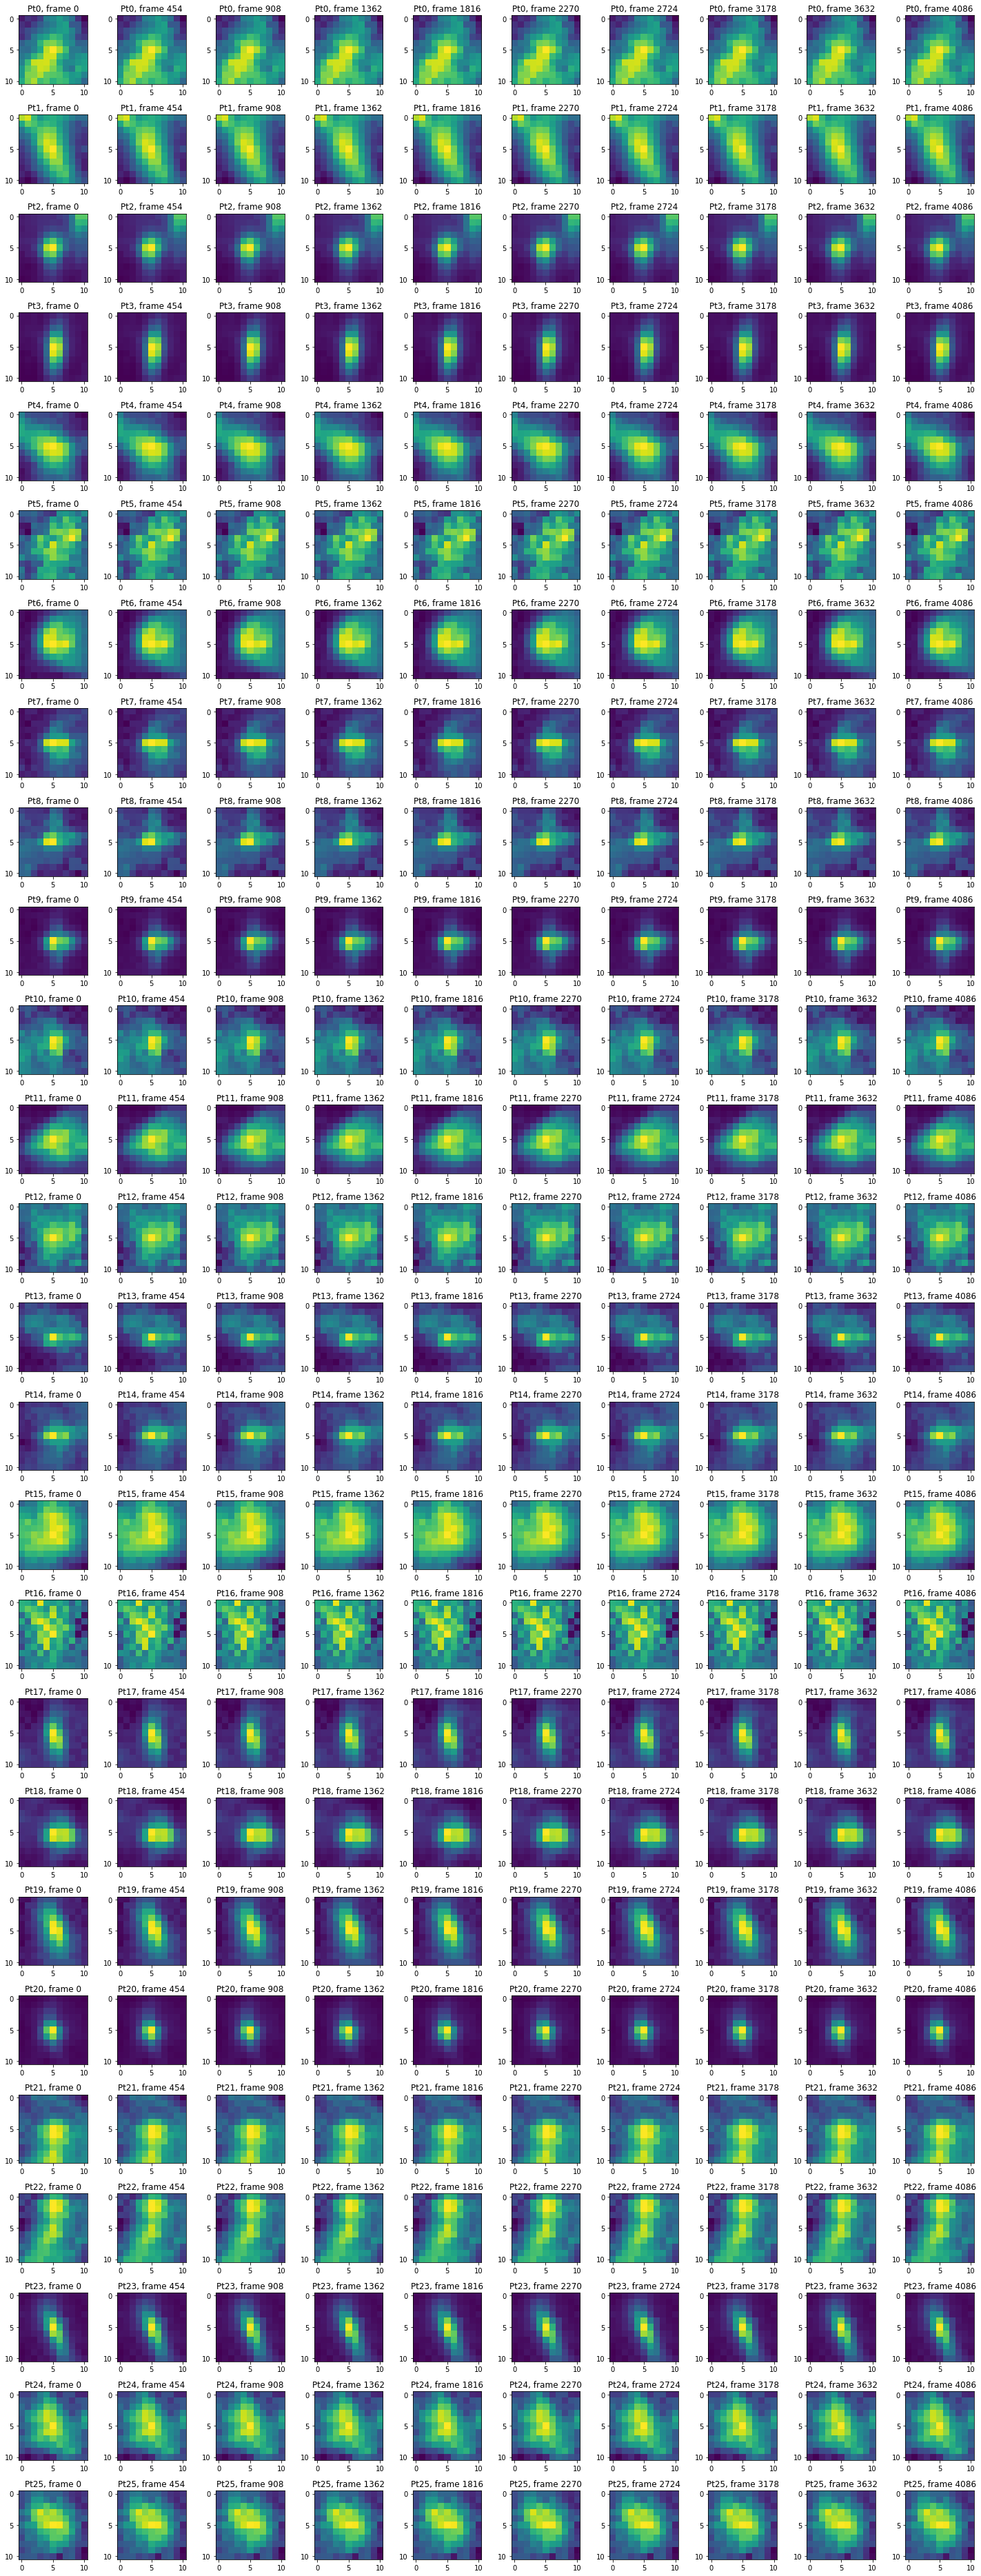

In [20]:
fig, ax = plt.subplots(len(pts),10, figsize=(20,2*len(pts)))
for i in range(len(pts)):
    for count, f in enumerate(np.linspace(0,movie.shape[0],10)):
        f = int(f)
        roi = ROI.get_roi_square_3d(pts[i], [5,5])
        ax[i,count].imshow(movie[NR][roi].mean(0))
        ax[i,count].set_title('Pt%d, frame %d' % (i,f))
fig.tight_layout()

### Select square ROI

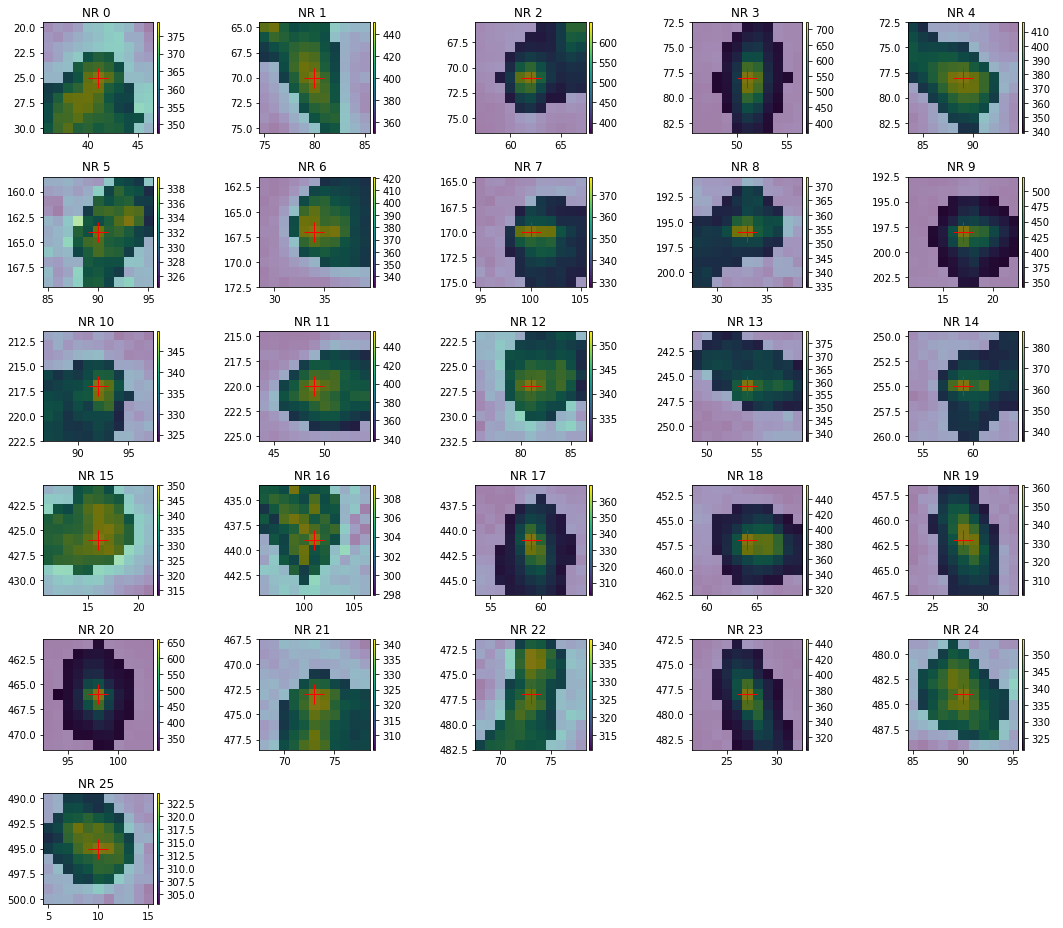

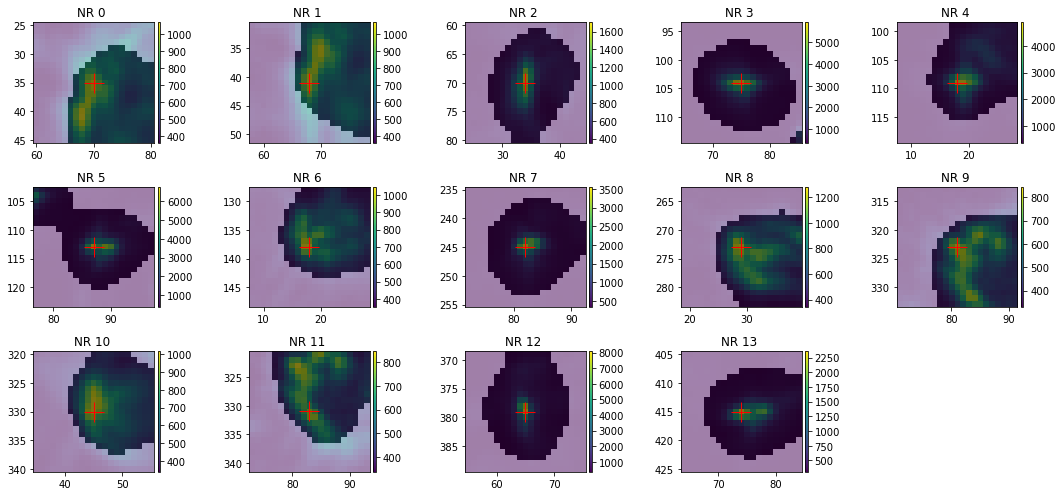

In [21]:
fig, ax = ROI.plot_roi_wMask(movie[NR].mean(0), pts, scan=[5,5], ncol=5)
display(fig)
fig, ax = ROI.plot_roi_wMask(movie[NR].mean(0), pts_agg, scan=[10,10], ncol=5, sigma=4)
display(fig)

### Find matching areas in both view

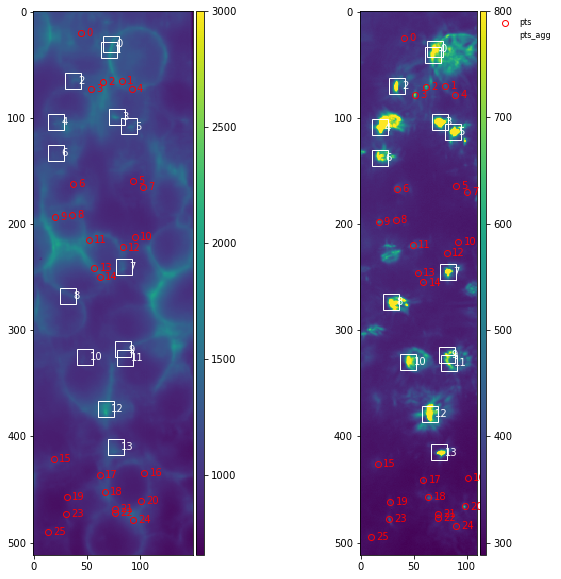

In [22]:
shift = (-3,5)

fig, ax = plt.subplots(1,2, figsize=(10,10))
ax[0].plot(pts[:,0]-shift[0], pts[:,1]-shift[1], 'ro', fillstyle='none', label='pts')
for count, pt in enumerate(pts):
    ax[0].annotate(count, xy=pt+[5,3]-shift, color='r', fontsize=10)
ax[0].plot(pts_agg[:,0]-shift[0], pts_agg[:,1]-shift[1], 'ws', fillstyle='none', label='pts_agg', ms=16)
for count, pt in enumerate(pts_agg):
    ax[0].annotate(count, xy=pt+[5,3]-shift, color='w', fontsize=10)

ax[1].plot(pts[:,0], pts[:,1], 'ro', fillstyle='none', label='pts')
for count, pt in enumerate(pts):
    ax[1].annotate(count, xy=pt+[5,3], color='r', fontsize=10)
ax[1].plot(pts_agg[:,0], pts_agg[:,1], 'ws', fillstyle='none', label='pts_agg', ms=16)
for count, pt in enumerate(pts_agg):
    ax[1].annotate(count, xy=pt+[5,3], color='w', fontsize=10)

im = {}
im['0'] = ax[0].imshow(movie[berst].mean(0), cmap='viridis', vmax=3000, interpolation='none')
im['1'] = ax[1].imshow(movie[NR].mean(0), cmap='viridis', vmax=800, interpolation='none')
ax[1].legend(frameon=False, bbox_to_anchor=(1.7, 1), fontsize=8)
for i in range(2):
    divider = make_axes_locatable(ax[i])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im[str(i)], cax=cax)

### Plot ROIs selected in BeRST channel

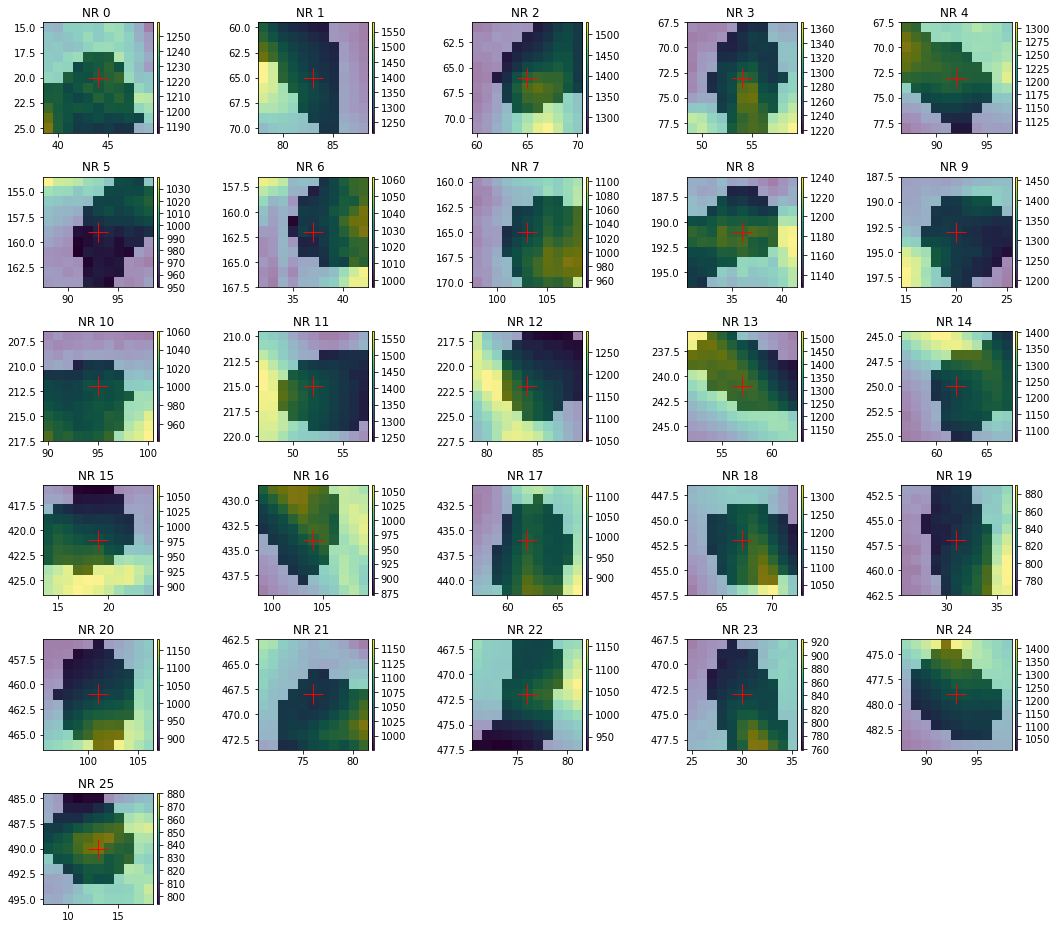

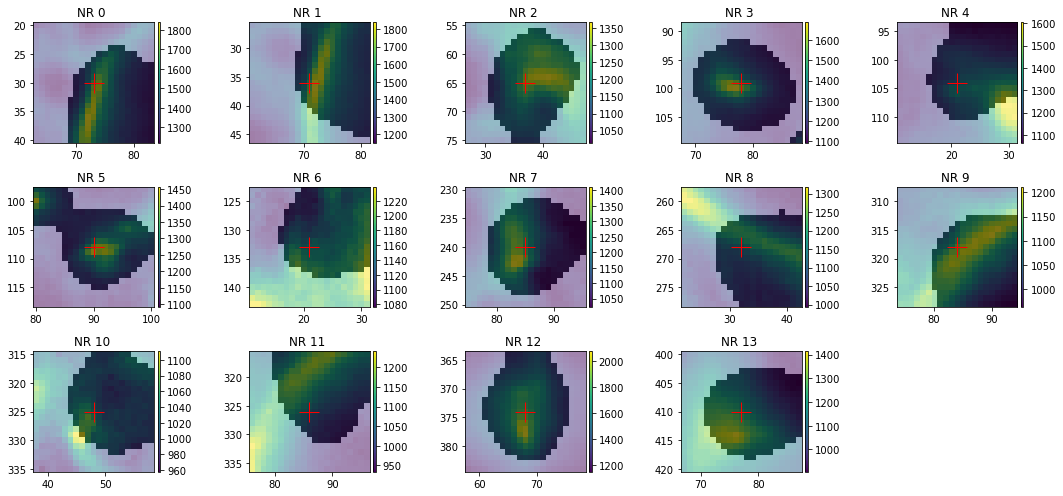

In [23]:
scan = [5,5]
fig, ax = ROI.plot_roi(movie[berst].mean(0), pts-shift, scan, ncol=5)
for count, pt in enumerate(pts):    
    roi = ROI.get_roi_square(pt, scan)
    mask = ROI.get_local_mask(movie[NR].mean(0), pt, scan=[5,5], sigma=2)
    extent = (roi[1].start-0.5-shift[0], roi[1].stop-0.5-shift[0], 
              roi[0].stop-0.5-shift[1], roi[0].start-0.5-shift[1])
    ax[count].imshow(mask, interpolation='none', extent=extent, cmap='gray_r', alpha=0.5)
display(fig)

scan = [10,10]
fig, ax = ROI.plot_roi(movie[berst].mean(0), pts_agg-shift, scan, ncol=5)
for count, pt in enumerate(pts_agg):    
    roi = ROI.get_roi_square(pt, scan)
    mask = ROI.get_local_mask(movie[NR].mean(0), pt, scan, sigma=4)
    extent = (roi[1].start-0.5-shift[0], roi[1].stop-0.5-shift[0], 
              roi[0].stop-0.5-shift[1], roi[0].start-0.5-shift[1])
    ax[count].imshow(mask, interpolation='none', extent=extent, cmap='gray_r', alpha=0.5)
display(fig)

## Plot time trace of small particles (5x5 ROIs)

In [24]:
T = np.arange(0, movie.shape[0]/framerate, 1/framerate)[:-1]

In [25]:
scan = [5,5]

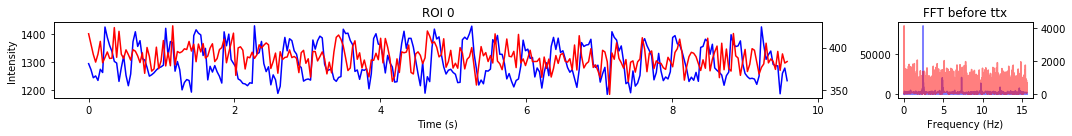

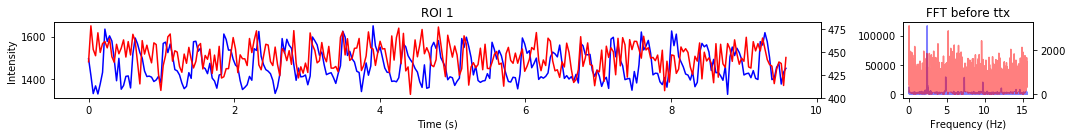

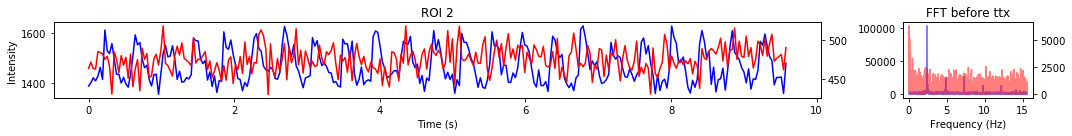

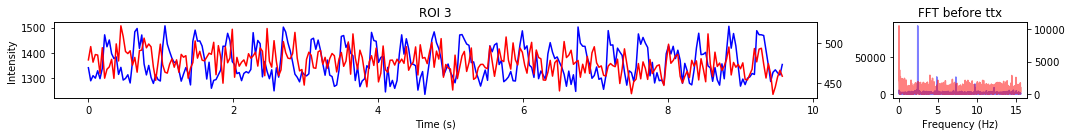

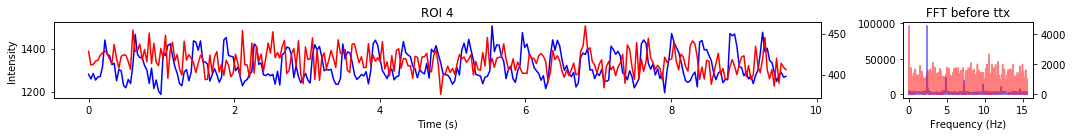

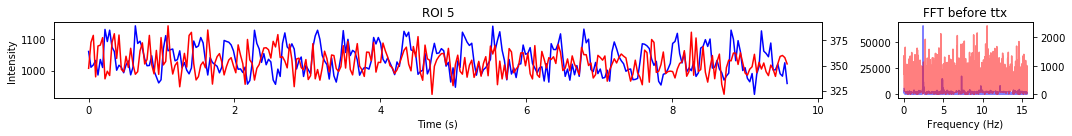

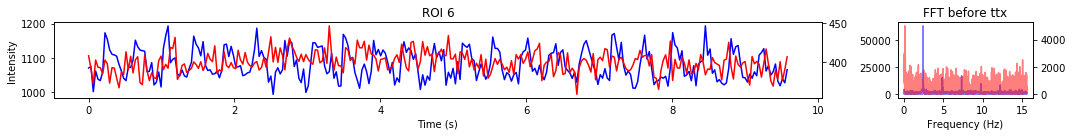

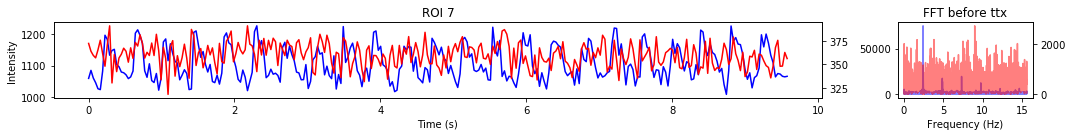

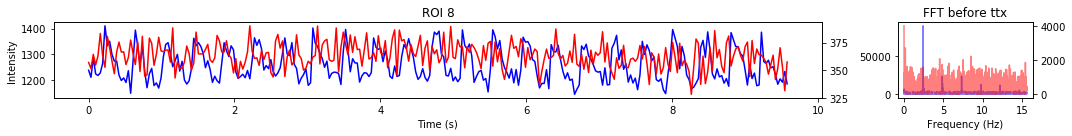

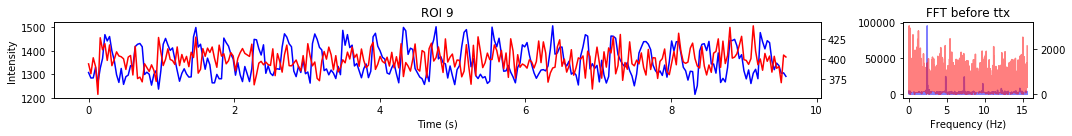

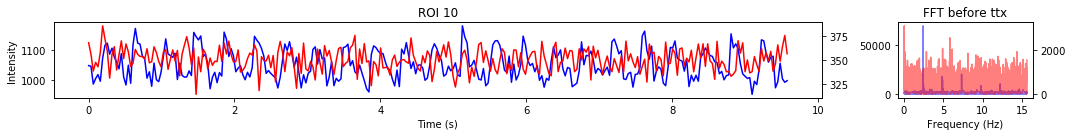

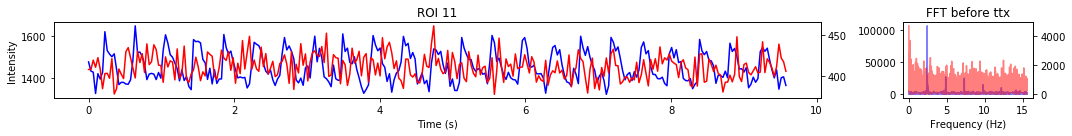

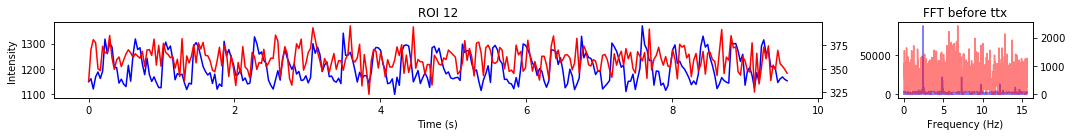

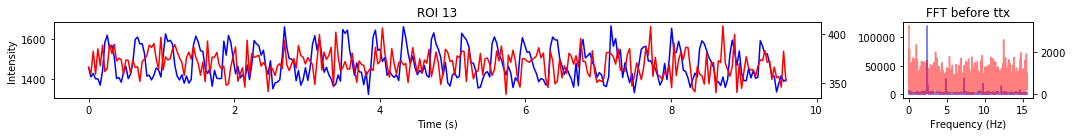

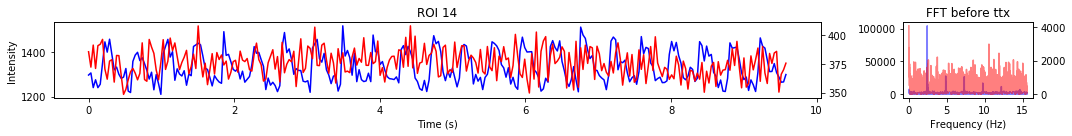

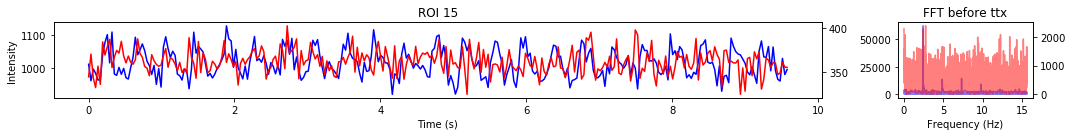

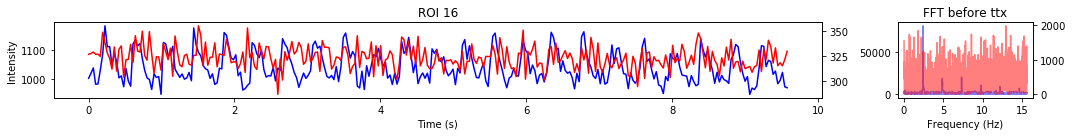

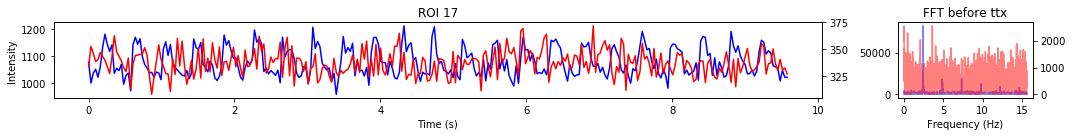

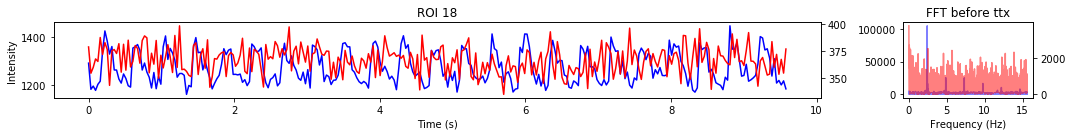

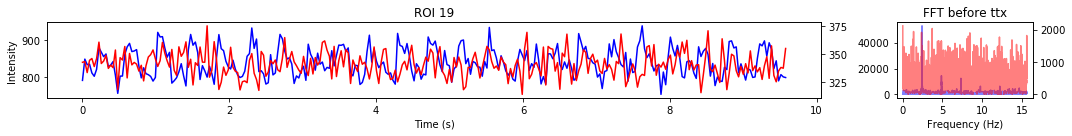

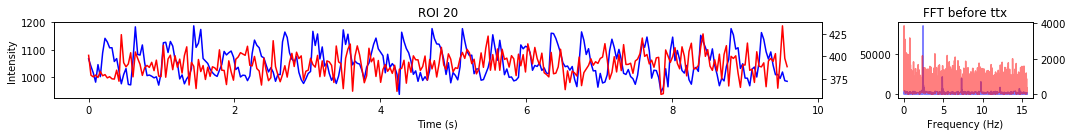

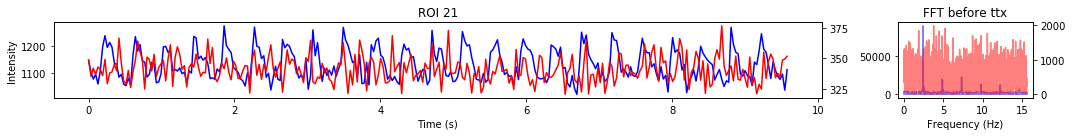

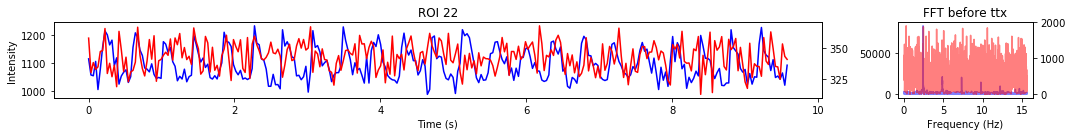

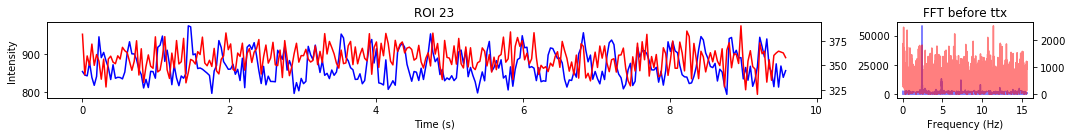

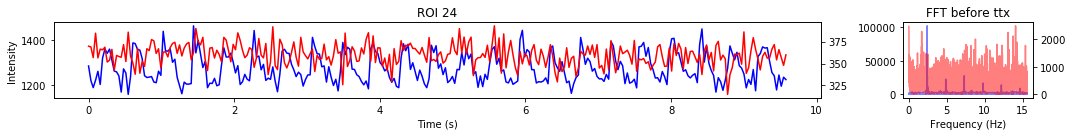

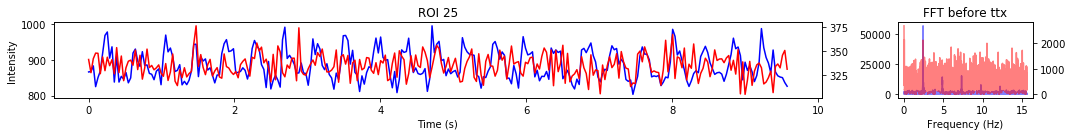

In [26]:
for count, pt in enumerate(pts):
    roi = ROI.get_roi_square_3d(pt, scan)
    mask = ROI.get_local_mask(movie[NR].mean(0), pt, scan, sigma=2)
    mask3d  = np.zeros((movie.shape[0], scan[0]*2+1, scan[1]*2+1))
    for i in range(movie.shape[0]):
        mask3d[i,:,:] = mask
    tt_NR = np.sum(np.sum(movie[NR][roi]*mask, axis=1), axis=1)/np.sum(mask)
 
    roi = ROI.get_roi_square_3d(pt-shift, scan)
    tt_berst = np.sum(np.sum(movie[berst][roi]*mask, axis=1), axis=1)/np.sum(mask)
    
    
    fig, ax = plt.subplots(1,5, figsize=(15,2))
    ax[0] = plt.subplot2grid((1,5), (0,0), colspan=4, rowspan=1)
    ax[4] = plt.subplot2grid((1,5), (0,4), colspan=1, rowspan=1)
    ax[0].plot(T[:300],tt_berst[:300], 'b')
    ax1 = ax[0].twinx()
    ax1.plot(T[:300],tt_NR[:300], 'r')
    
    ax[4].plot(get_rfft_wMirrorExt(tt_berst[:1500], framerate)[0][2:], 
               get_rfft_wMirrorExt(tt_berst[:1500], framerate)[1][2:], 'b', alpha=0.5)
    ax5 = ax[4].twinx()
    ax5.plot(get_rfft_wMirrorExt(tt_NR[:1500], framerate)[0][2:], 
             get_rfft_wMirrorExt(tt_NR[:1500], framerate)[1][2:], 'r', alpha=0.5)
    
    ax[0].set_title('ROI %d' % count)
    ax[0].set_xlabel('Time (s)')
    ax[0].set_ylabel('Intensity')
    ax[4].set_title('FFT before ttx')
    ax[4].set_xlabel('Frequency (Hz)')
    fig.tight_layout()
    plt.close(fig)
    display(fig)

## Plot time trace of huge aggregates (10x10 ROIs)

In [27]:
T = np.arange(0, movie.shape[0]/framerate, 1/framerate)[:-1]

In [28]:
scan = [10,10]

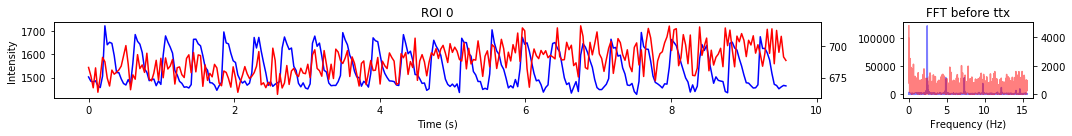

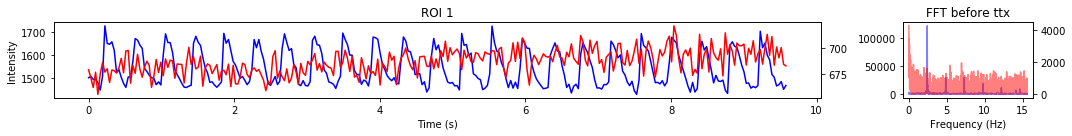

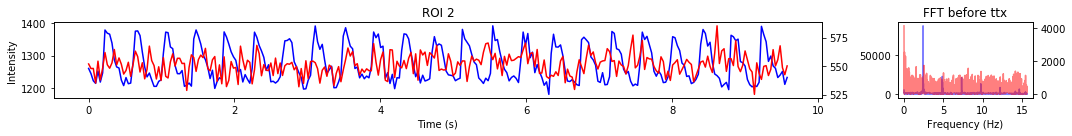

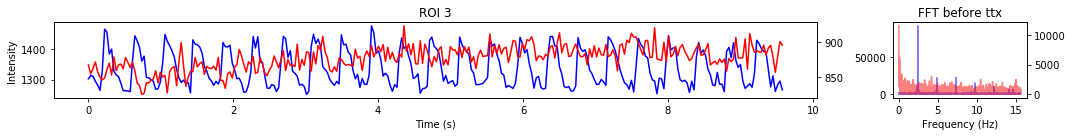

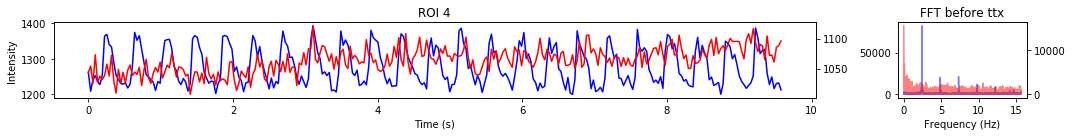

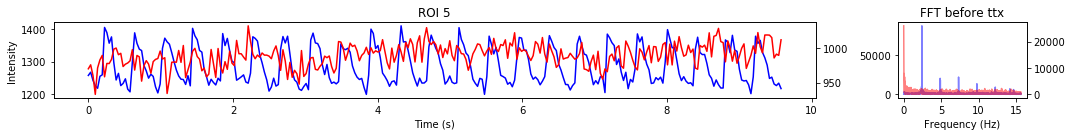

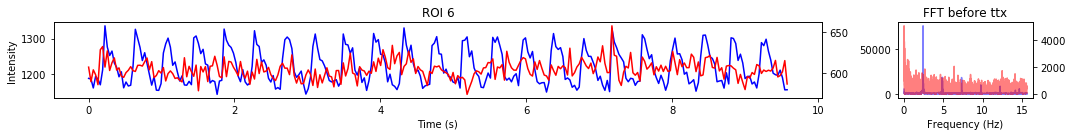

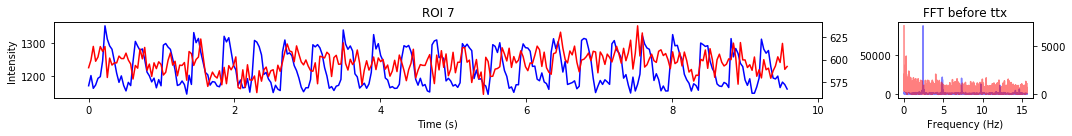

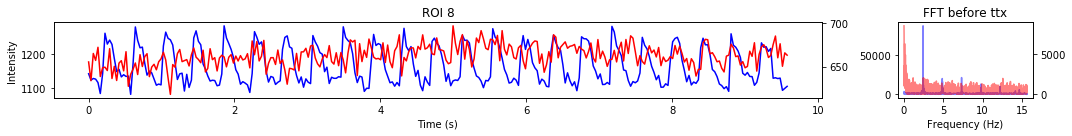

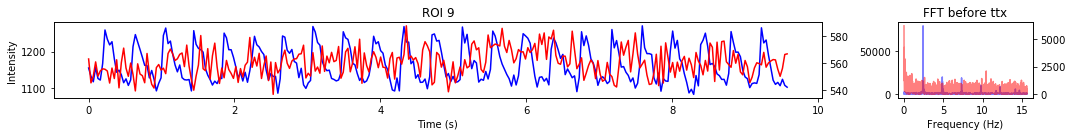

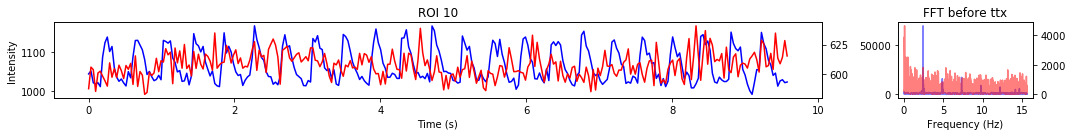

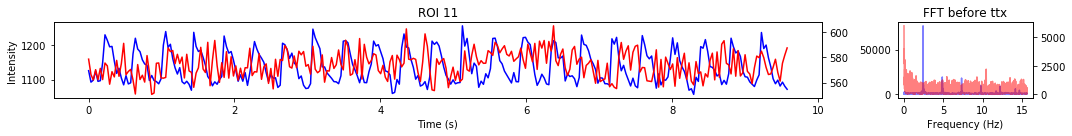

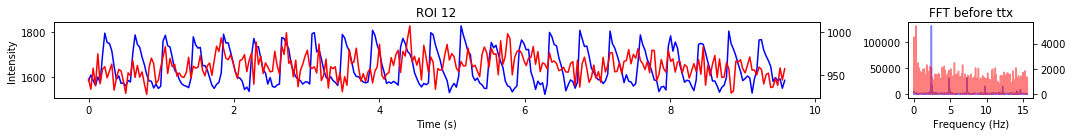

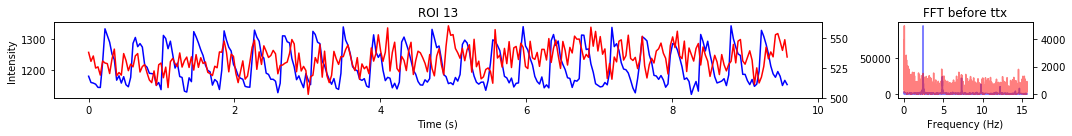

In [29]:
for count, pt in enumerate(pts_agg):
    roi = ROI.get_roi_square_3d(pt, scan)
    mask = ROI.get_local_mask(movie[NR].mean(0), pt, scan, sigma=4)
    mask3d  = np.zeros((movie.shape[0], scan[0]*2+1, scan[1]*2+1))
    for i in range(movie.shape[0]):
        mask3d[i,:,:] = mask
    tt_NR = np.sum(np.sum(movie[NR][roi]*mask, axis=1), axis=1)/np.sum(mask)
 
    roi = ROI.get_roi_square_3d(pt-shift, scan)
    tt_berst = np.sum(np.sum(movie[berst][roi]*mask, axis=1), axis=1)/np.sum(mask)
    
    
    fig, ax = plt.subplots(1,5, figsize=(15,2))
    ax[0] = plt.subplot2grid((1,5), (0,0), colspan=4, rowspan=1)
    ax[4] = plt.subplot2grid((1,5), (0,4), colspan=1, rowspan=1)
    ax[0].plot(T[:300],tt_berst[:300], 'b')
    ax1 = ax[0].twinx()
    ax1.plot(T[:300],tt_NR[:300], 'r')
    
    ax[4].plot(get_rfft_wMirrorExt(tt_berst[:1500], framerate)[0][2:], 
               get_rfft_wMirrorExt(tt_berst[:1500], framerate)[1][2:], 'b', alpha=0.5)
    ax5 = ax[4].twinx()
    ax5.plot(get_rfft_wMirrorExt(tt_NR[:1500], framerate)[0][2:], 
             get_rfft_wMirrorExt(tt_NR[:1500], framerate)[1][2:], 'r', alpha=0.5)
     
    ax[0].set_title('ROI %d' % count)
    ax[0].set_xlabel('Time (s)')
    ax[0].set_ylabel('Intensity')
    ax[4].set_title('FFT before ttx')
    ax[4].set_xlabel('Frequency (Hz)')
    fig.tight_layout()
    plt.close(fig)
    display(fig)

## Time trace as function of ROI size

In [30]:
NR

(slice(None, None, None), slice(0, 512, None), slice(320, 430, None))

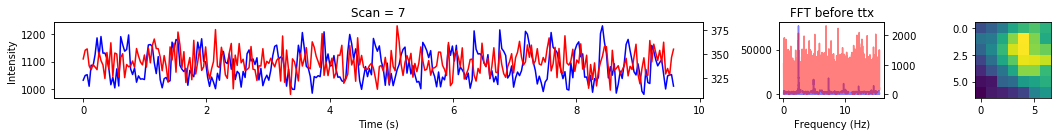

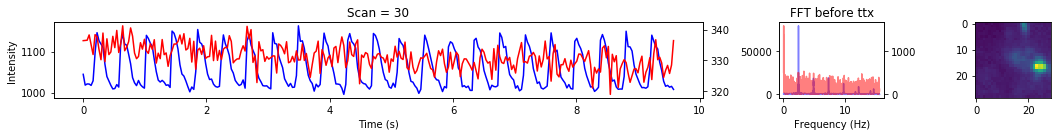

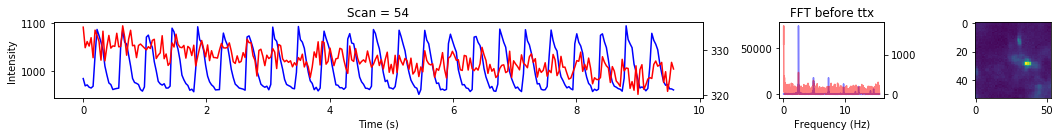

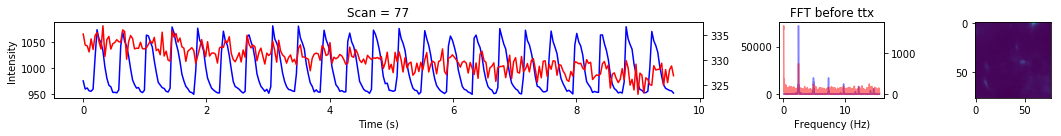

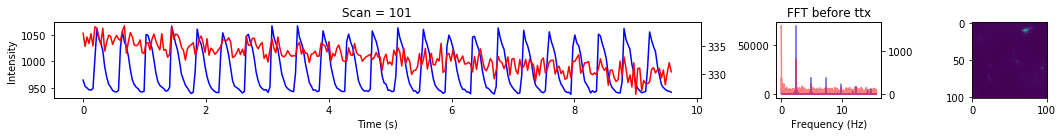

In [31]:
for i, r in enumerate(np.linspace(3,50,5)):
    pt = np.array([55,455])
    scan = [int(r),int(r)]
    roi = ROI.get_roi_square_3d(pt, scan)
    tt_berst = ROI.get_timetrace(movie[berst], pt-shift, scan)
    tt_NR = ROI.get_timetrace(movie[NR], pt, scan)
    
    
    fig, ax = plt.subplots(1,6, figsize=(15,2))
    ax[0] = plt.subplot2grid((1,6), (0,0), colspan=4, rowspan=1)
    ax[4] = plt.subplot2grid((1,6), (0,4), colspan=1, rowspan=1)
    ax[5] = plt.subplot2grid((1,6), (0,5), colspan=1, rowspan=1)
    
    ax[0].plot(T[:300],tt_berst[:300], 'b')
    ax1 = ax[0].twinx()
    ax1.plot(T[:300],tt_NR[:300], 'r')
    
    ax[4].plot(get_rfft_wMirrorExt(tt_berst[:1500], framerate)[0][2:], 
               get_rfft_wMirrorExt(tt_berst[:1500], framerate)[1][2:], 'b', alpha=0.5)
    ax5 = ax[4].twinx()
    ax5.plot(get_rfft_wMirrorExt(tt_NR[:1500], framerate)[0][2:], 
             get_rfft_wMirrorExt(tt_NR[:1500], framerate)[1][2:], 'r', alpha=0.5)
    
    ax[5].imshow(movie[NR][roi].mean(0))
    
    ax[0].set_title('Scan = %d' % (r*2+1))
    ax[0].set_xlabel('Time (s)')
    ax[0].set_ylabel('Intensity')
    ax[4].set_title('FFT before ttx')
    ax[4].set_xlabel('Frequency (Hz)')
    fig.tight_layout()
    plt.close(fig)
    display(fig)

## Time trace as function of ROI size, excluding bright spots

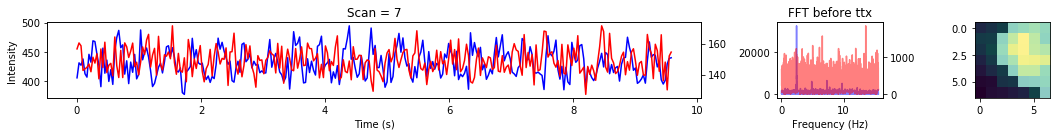

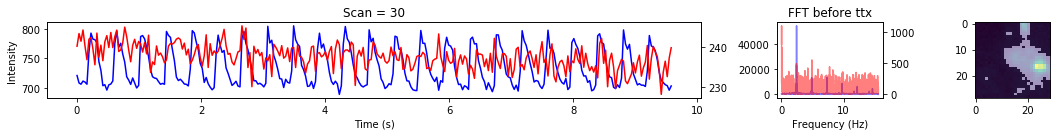

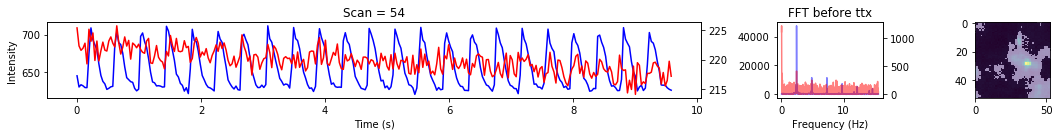

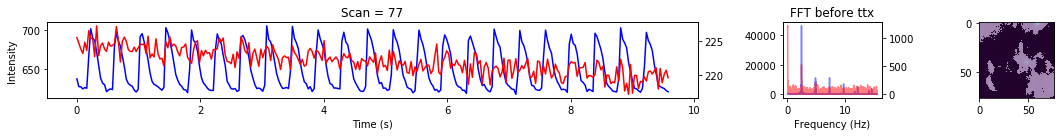

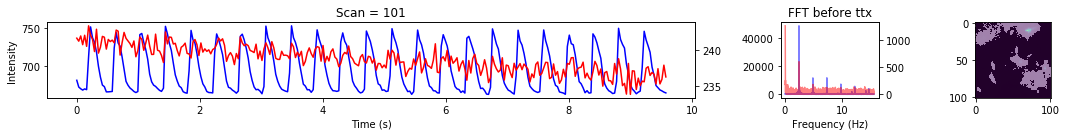

In [32]:
for i, r in enumerate(np.linspace(3,50,5)):
    pt = np.array([55,455])
    scan = [int(r),int(r)]
    roi = ROI.get_roi_square_3d(pt, scan)
    mask = movie[NR][roi].mean(0) < np.mean(movie[NR][roi].mean(0))
    tt_berst = np.mean(np.mean(movie[berst][roi]*mask, axis=1), axis=1)
    tt_NR = np.mean(np.mean(movie[NR][roi]*mask, axis=1), axis=1)
    
    
    fig, ax = plt.subplots(1,6, figsize=(15,2))
    ax[0] = plt.subplot2grid((1,6), (0,0), colspan=4, rowspan=1)
    ax[4] = plt.subplot2grid((1,6), (0,4), colspan=1, rowspan=1)
    ax[5] = plt.subplot2grid((1,6), (0,5), colspan=1, rowspan=1)
    
    ax[0].plot(T[:300],tt_berst[:300], 'b')
    ax1 = ax[0].twinx()
    ax1.plot(T[:300],tt_NR[:300], 'r')
    
    ax[4].plot(get_rfft_wMirrorExt(tt_berst[:1500], framerate)[0][2:], 
               get_rfft_wMirrorExt(tt_berst[:1500], framerate)[1][2:], 'b', alpha=0.5)
    ax5 = ax[4].twinx()
    ax5.plot(get_rfft_wMirrorExt(tt_NR[:1500], framerate)[0][2:], 
             get_rfft_wMirrorExt(tt_NR[:1500], framerate)[1][2:], 'r', alpha=0.5)
    
    ax[5].imshow((movie[NR][roi]).mean(0))
    ax[5].imshow(mask, cmap='gray_r', alpha=0.5)
    
    ax[0].set_title('Scan = %d' % (r*2+1))
    ax[0].set_xlabel('Time (s)')
    ax[0].set_ylabel('Intensity')
    ax[4].set_title('FFT before ttx')
    ax[4].set_xlabel('Frequency (Hz)')
    fig.tight_layout()
    plt.close(fig)
    display(fig)

## FFT to exam where signals are from

In [33]:
berst_fft = np.zeros((1500, movie[berst].shape[1], movie[berst].shape[2]))
berst_norm = np.zeros((1500, movie[berst].shape[1], movie[berst].shape[2]))
for i in range(movie[berst].shape[1]):
    for j in range(movie[berst].shape[2]):
        m = movie[berst][:1500,i,j]-movie[berst][:1500,i,j].min()
        m = m/m.max()
        berst_norm[:,i,j] = m
        berst_fft[:,i,j] = get_rfft_wMirrorExt(m, framerate)[1]

In [34]:
NR_fft = np.zeros((1500, movie[NR].shape[1], movie[NR].shape[2]))
NR_norm = np.zeros((1500, movie[NR].shape[1], movie[NR].shape[2]))
for i in range(movie[NR].shape[1]):
    for j in range(movie[NR].shape[2]):
        m = movie[NR][:1500,i,j]-movie[NR][:1500,i,j].min()
        m = m/m.max()
        NR_norm[:,i,j] = m
        NR_fft[:,i,j] = get_rfft_wMirrorExt(m, framerate)[1]

In [37]:
freq = get_rfft_wMirrorExt(m, framerate)[0]

berst_norm = movie[berst][:1500]/movie[berst][:1500].mean(0)
berst_fft = np.zeros((1500, movie[berst].shape[1], movie[berst].shape[2]))
for i in range(movie[berst].shape[1]):
    for j in range(movie[berst].shape[2]):
        berst_fft[:,i,j] = get_rfft_wMirrorExt(berst_norm[:,i,j], framerate)[1]

NR_norm = movie[NR][:1500]/movie[NR][:1500].mean(0)
NR_fft = np.zeros((1500, movie[NR].shape[1], movie[NR].shape[2]))
for i in range(movie[NR].shape[1]):
    for j in range(movie[NR].shape[2]):
        NR_fft[:,i,j] = get_rfft_wMirrorExt(NR_norm[:,i,j], framerate)[1]

movie2 = np.append(movie[berst][:1500], movie[berst][:1500][:0:-1]).reshape((2999,movie[berst].shape[1],movie[berst].shape[2]))
N = movie2.shape[0]
berst_fft = np.fft.rfft(movie2, axis=0)
freq = np.fft.rfftfreq(N, d=1./framerate)

movie2 = np.append(movie[NR][:1500], movie[NR][:1500][:0:-1]).reshape((2999,movie[NR].shape[1],movie[NR].shape[2]))
NR_fft = np.fft.rfft(movie2, axis=0)

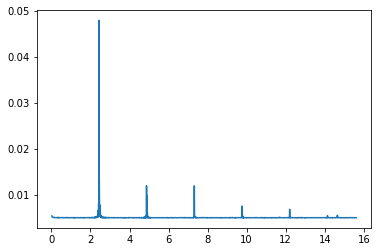

In [38]:
fft = np.abs(berst_fft.real.mean(1).mean(1))
fft = fft/fft[0]
plt.plot(freq[2:], fft[2:])

In [42]:
peaks = freq[np.where(fft>0.01)[0]]
peaks = peaks[peaks>1.5]
print(peaks)

[ 2.43605002  2.44646049  2.45687096  4.87210003  7.31856052]


In [43]:
peaks.shape

(5,)

In [44]:
bases = freq[np.where(fft<0.01)[0]]

In [45]:
np.searchsorted(freq, peaks)

array([234, 235, 236, 468, 703])

### Plot sum image of at frequency = peaks

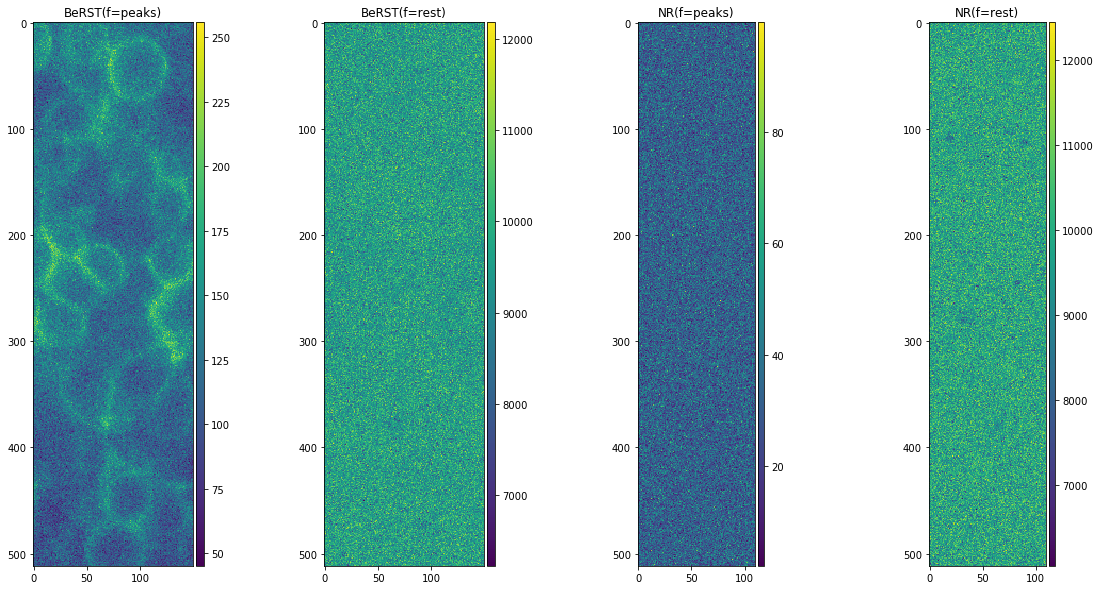

In [46]:
berst_img = np.sum(berst_fft[np.searchsorted(freq, peaks)], axis=0)
NR_img = np.sum(NR_fft[np.searchsorted(freq, peaks)], axis=0)
berst_imgb = np.sum(berst_fft[np.searchsorted(freq, bases)], axis=0)
NR_imgb = np.sum(NR_fft[np.searchsorted(freq, bases)], axis=0)

im = {}
fig, ax = plt.subplots(1,4,figsize=(20,10))
im['0'] = ax[0].imshow(berst_img)
im['1'] = ax[1].imshow(berst_imgb)
im['2'] = ax[2].imshow(NR_img)
im['3'] = ax[3].imshow(NR_imgb)
ax[0].set_title('BeRST(f=peaks)')
ax[1].set_title('BeRST(f=rest)')
ax[2].set_title('NR(f=peaks)')
ax[3].set_title('NR(f=rest)')
for i in range(4):
    divider = make_axes_locatable(ax[i])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im[str(i)], cax=cax)

## Group pixels by intensity and exam subgorup's fft

In [110]:
import matplotlib as mpl
cmap = plt.cm.gist_ncar
cmaplist = [cmap(i) for i in range(cmap.N)]
cmaplist[0] = (.5,.5,.5,1.0)
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

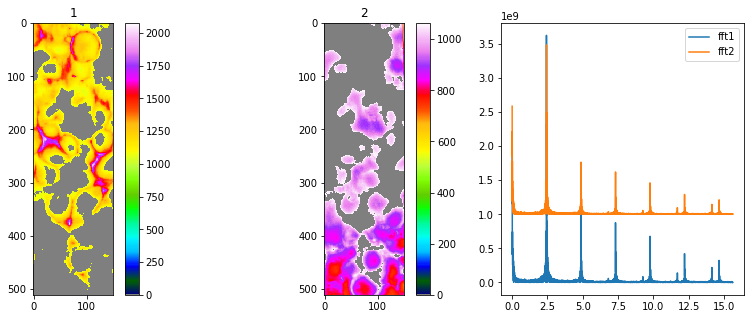

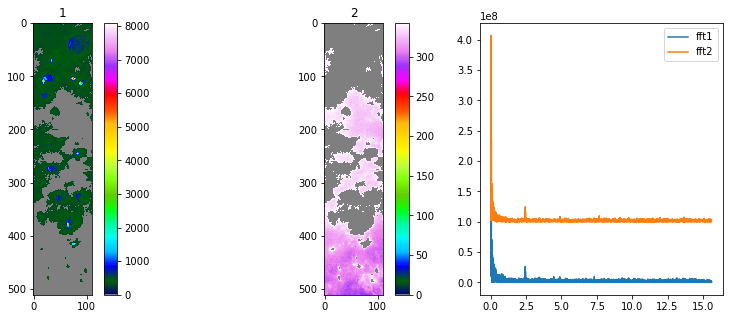

In [139]:
img = movie[berst].mean(0)
mask = img > np.median(img)
fft1 = get_rfft_wMirrorExt(np.sum(np.sum(movie[berst]*mask, axis=1), axis=1), framerate)
fft2 = get_rfft_wMirrorExt(np.sum(np.sum(movie[berst]*~mask, axis=1), axis=1), framerate)
plt.figure(figsize=(20,5))
plt.subplot(141)
plt.imshow(img*mask, cmap=cmap)
plt.colorbar()
plt.title('1')
plt.subplot(142)
plt.imshow(img*~mask, cmap=cmap)
plt.colorbar()
plt.title('2')
plt.subplot(143)
plt.plot(fft1[0][2:],fft1[1][2:], label='fft1')
plt.plot(fft2[0][2:],fft2[1][2:]+1e9, label='fft2')
plt.legend()

img = movie[NR].mean(0)
mask = img > np.median(img)
fft1 = get_rfft_wMirrorExt(np.sum(np.sum(movie[NR]*mask, axis=1), axis=1), framerate)
fft2 = get_rfft_wMirrorExt(np.sum(np.sum(movie[NR]*~mask, axis=1), axis=1), framerate)
plt.figure(figsize=(20,5))
plt.subplot(141)
plt.imshow(img*mask, cmap=cmap)
plt.colorbar()
plt.title('1')
plt.subplot(142)
plt.imshow(img*~mask, cmap=cmap)
plt.colorbar()
plt.title('2')
plt.subplot(143)
plt.plot(fft1[0][2:],fft1[1][2:], label='fft1')
plt.plot(fft2[0][2:],fft2[1][2:]+1e8, label='fft2')
plt.legend()

## Sort and group pixels by mean intensity (e.g. into 20 or 30 subgroups)

In [49]:
ngroup = 30

(76800,) (56320,)


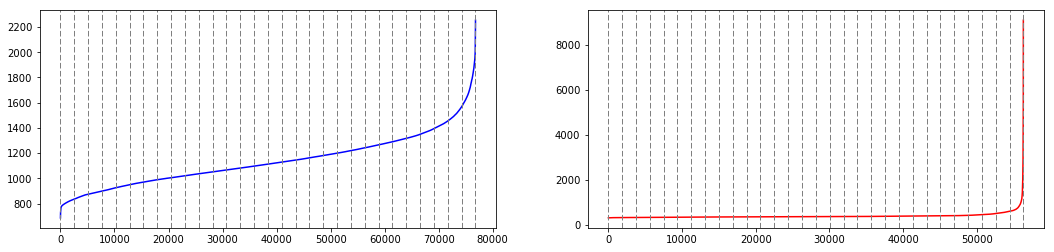

In [50]:
sorted_Iberst = np.sort(movie[berst][:1500].mean(0).flatten())
sorted_INR = np.sort(movie[NR][:1500].mean(0).flatten())
fig, ax = plt.subplots(1,2, figsize=(18,4))
ax[0].plot(sorted_Iberst, 'b')
ax[1].plot(sorted_INR, 'r')
for i in range(ngroup+1):
    ax[0].axvline(x = sorted_Iberst.shape[0]/ngroup*i, ls='dashed', lw=1, color='gray')
for i in range(ngroup+1):
    ax[1].axvline(x = sorted_INR.shape[0]/ngroup*i, ls='dashed', lw=1, color='gray')
print(sorted_Iberst.shape, sorted_INR.shape)

### Plot pixels of each subgroups 
### Plot FFT spectrum of those pixels in each subgroups

In [51]:
print(sorted_Iberst.shape[0]/ngroup, sorted_INR.shape[0]/ngroup)

2560.0 1877.3333333333333


In [52]:
gberst = []
gNR = []
for i in range(ngroup):
    idx = np.arange(int(sorted_Iberst.shape[0]/ngroup*i), int(sorted_Iberst.shape[0]/ngroup*(i+1)))
    I = sorted_Iberst[idx]
    mask = np.logical_and(movie[berst][:1500].mean(0)>=I.min(), 
                          movie[berst][:1500].mean(0)<=I.max())
    gberst = np.append(gberst, mask)
    
    idx = np.arange(int(sorted_INR.shape[0]/ngroup*i), int(sorted_INR.shape[0]/ngroup*(i+1)))
    I = sorted_INR[idx]
    mask = np.logical_and(movie[NR][:1500].mean(0)>=I.min(), 
                          movie[NR][:1500].mean(0)<=I.max())
    gNR = np.append(gNR, mask)
gberst = gberst.reshape((ngroup, movie[berst].shape[1], movie[berst].shape[2]))
gNR = gNR.reshape((ngroup, movie[NR].shape[1], movie[NR].shape[2]))

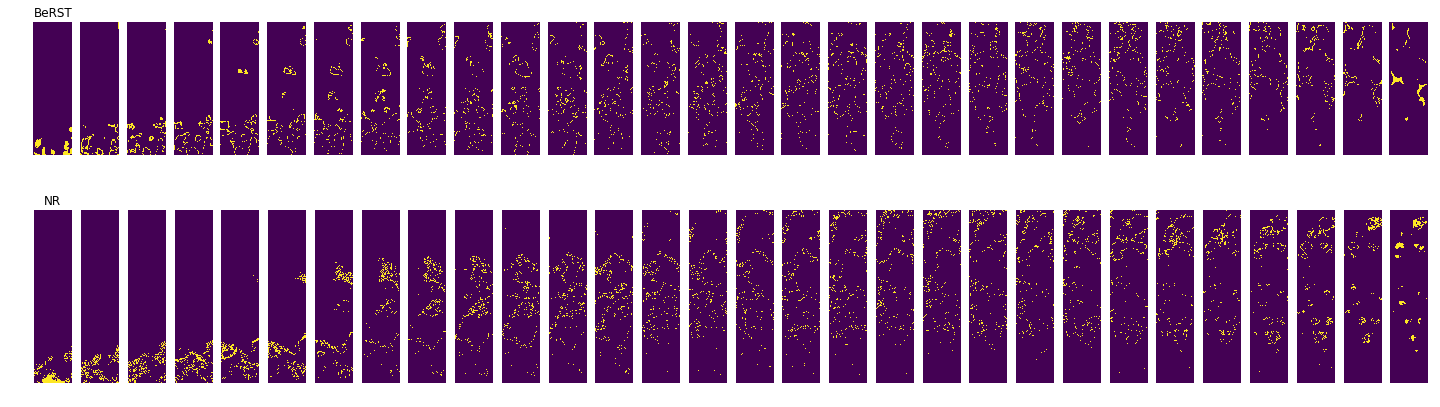

In [53]:
fig, ax = plt.subplots(2, ngroup, figsize=(25,7))
for i in range(ngroup):
    ax[0,i].imshow(gberst[i,:,:])
    ax[1,i].imshow(gNR[i,:,:])
ax = ax.ravel()
for a in ax:
    a.patch.set_visible(False)
    a.axis('off')
ax[0].set_title('BeRST')
ax[ngroup].set_title('NR')

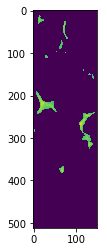

In [54]:
plt.imshow(np.mean(gberst[i,:,:]*movie[berst][:1500], axis=0))

(-1, 1600)

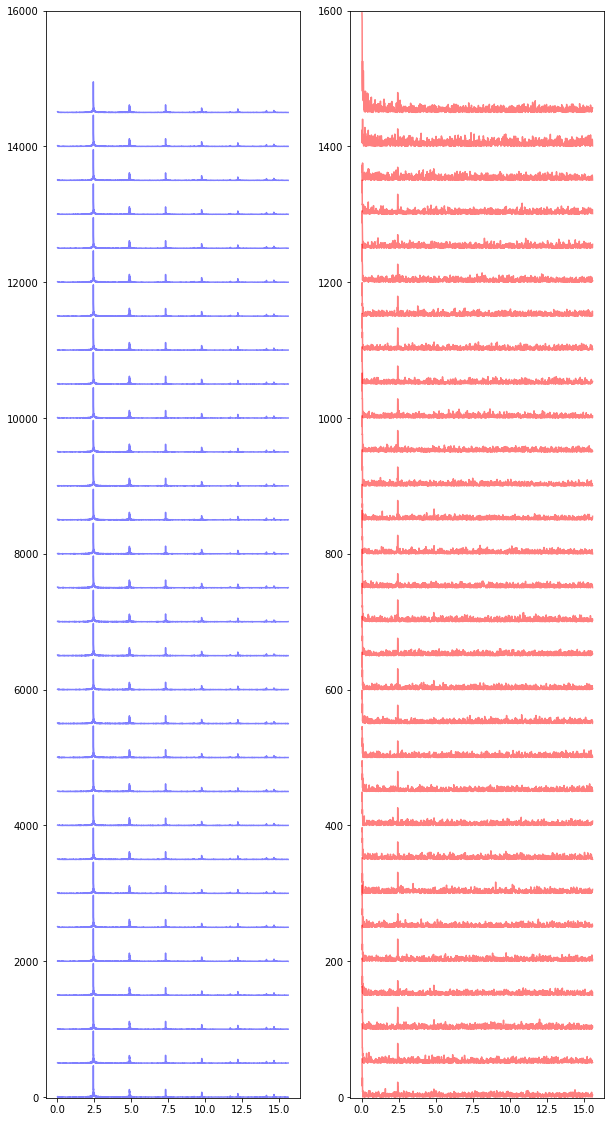

In [59]:
Ab = []
An = []
fig, ax = plt.subplots(1,2, figsize=(10,20))
for i in range(ngroup):
    tt = np.sum(np.sum(gberst[i,:,:]*berst_norm, axis=1), axis=1)
    tt = tt-tt.min()
    tt = tt/tt.max()
    ax[0].plot(get_rfft_wMirrorExt(tt, framerate)[0][2:], 
               get_rfft_wMirrorExt(tt, framerate)[1][2:]+i*500, 'b', alpha=0.5)
    A1 = get_rfft_wMirrorExt(tt, framerate)[1]
    idx = np.where(A1[200:250]==A1[200:250].max())[0]+200
    #print(A1[idx], idx)
    Ab.append(A1[idx])#/A1[0])
    
    tt = np.sum(np.sum(gNR[i,:,:]*NR_norm, axis=1), axis=1)
    tt = tt-tt.min()
    tt = tt/tt.max()
    ax[1].plot(get_rfft_wMirrorExt(tt, framerate)[0][2:], 
               get_rfft_wMirrorExt(tt, framerate)[1][2:]+i*50, 'r', alpha=0.5)
    A1 = get_rfft_wMirrorExt(tt, framerate)[1]
    idx = np.where(A1[200:250]==A1[200:250].max())[0]+200
    #print(A1[idx], idx)
    An.append(A1[idx])#/A1[0])
    
ax[0].set_ylim(-10,16000)
ax[1].set_ylim(-1,1600)

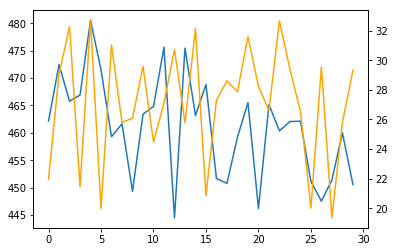

In [60]:
plt.plot(Ab)
ax = plt.twinx()
ax.plot(An, 'orange')

In [63]:
A = np.arange(ngroup)

In [105]:
#discrete color map
import matplotlib as mpl
cmap = plt.cm.gist_ncar
cmaplist = [cmap(i) for i in range(cmap.N)]
cmaplist[0] = (.5,.5,.5,1.0)
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

#define the bins and normalize
bounds = np.linspace(0,ngroup,ngroup+1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

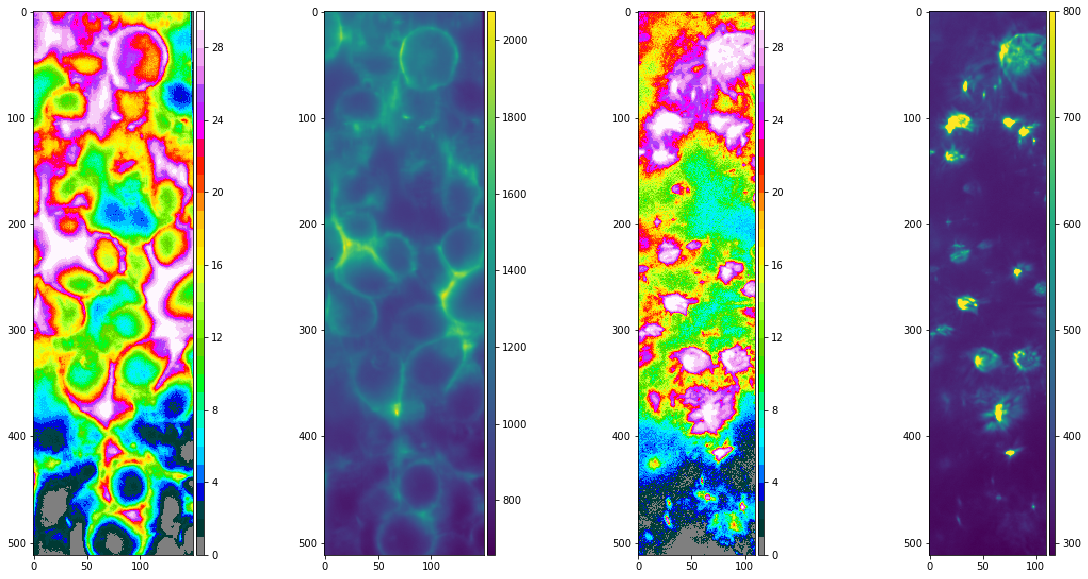

In [69]:
B = np.repeat(A, (gberst.shape[1]*gberst.shape[2])).reshape((ngroup,gberst.shape[1],gberst.shape[2]))
N = np.repeat(A, (gNR.shape[1]*gNR.shape[2])).reshape((ngroup,gNR.shape[1],gNR.shape[2]))
im = {}
fig, ax = plt.subplots(1,4, figsize=(20,10))
im['0'] = ax[0].imshow(np.sum(B*gberst, axis=0), 
                       interpolation=None, vmin=np.min(A), vmax=np.max(A), cmap=cmap, norm=norm)
im['1'] = ax[1].imshow(movie[berst].mean(0), interpolation=None)
im['2'] = ax[2].imshow(np.sum(N*gNR, axis=0), 
                       interpolation=None, vmin=np.min(A), vmax=np.max(A), cmap=cmap, norm=norm)
im['3'] = ax[3].imshow(movie[NR].mean(0), interpolation=None, vmax=800)
for i in range(4):
    divider = make_axes_locatable(ax[i])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im[str(i)], cax=cax)

In [133]:
mask = np.zeros(movie[NR].mean(0).shape)
for pt in pts:
    roi = ROI.get_roi_square(pt, [5,5])
    mask[roi] = 1
for pt in pts_agg:
    roi = ROI.get_roi_square(pt, [15,15])
    mask[roi] = 1

In [135]:
mask.sum(), mask.flatten().shape[0]

(14551.0, 56320)

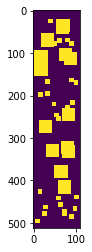

In [136]:
plt.imshow(mask)

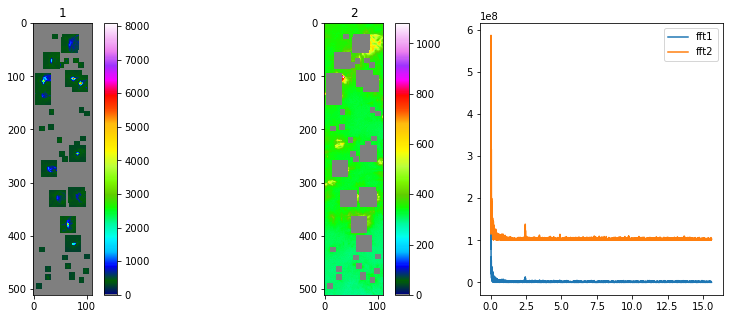

In [138]:
img = movie[NR].mean(0)
fft1 = get_rfft_wMirrorExt(np.sum(np.sum(movie[NR]*mask, axis=1), axis=1), framerate)
fft2 = get_rfft_wMirrorExt(np.sum(np.sum(movie[NR]*(1-mask), axis=1), axis=1), framerate)
plt.figure(figsize=(20,5))
plt.subplot(141)
plt.imshow(img*mask, cmap=cmap)
plt.colorbar()
plt.title('1')
plt.subplot(142)
plt.imshow(img*(1-mask), cmap=cmap)
plt.colorbar()
plt.title('2')
plt.subplot(143)
plt.plot(fft1[0][2:],fft1[1][2:], label='fft1')
plt.plot(fft2[0][2:],fft2[1][2:]+1e8, label='fft2')
plt.legend()

def get_acr(movie, pt, pad):
    tt = ROI.get_timetrace(movie, pt, pad)
    tt = tt - np.mean(tt[:])
    acr = np.correlate(tt, tt, mode='full')
    acr = acr[len(acr)//2:]
    return acr

def get_ccr(movie, pt, pad):
    tt = ROI.get_timetrace(movie, pt, pad)
    tt = tt - np.mean(tt[:])
    ccr = np.correlate(tt, V[::1000], mode='valid')
    return ccr

NRacr_movie = np.zeros(movie[NR].shape)
for i in range(movie[NR].shape[1]):
    for j in range(movie[NR].shape[2]):
        NRacr_movie[:,i,j] = get_acr(movie[NR], [j,i], [0,0])

NRacr_movie.shape

scan = [5,5]

from matplotlib.colors import LogNorm
acr_image = NRacr_movie[0]
acr_pts = ROI.finddot(acr_image, scan, 0.9)
print('len(acr_pts) = {}'.format(len(acr_pts)))

fig, ax = plt.subplots(figsize=(8,10))
ax.plot(pts[:,0], pts[:,1], 'bo', fillstyle='none', label='pts')
for count, pt in enumerate(pts):
    ax.annotate(count, xy=pt+[5,3], color='b', fontsize=6)
ax.plot(acr_pts[:,0], acr_pts[:,1], 'cs', fillstyle='none', label='ACR')
for count, pt in enumerate(acr_pts):
    ax.annotate(count, xy=pt+[5,3], color='c', fontsize=6)
im = ax.imshow(acr_image, interpolation='none', norm=LogNorm(), cmap='afmhot', vmax=1e8)
ax.legend(frameon=False, bbox_to_anchor=(1.9, 1), fontsize=8)
plt.colorbar(im)
plt.title('F-F autocorrelation sum')

### Define background

sigma = 20
movie_LPed = np.zeros(movie[NR].shape)
for i in range(movie[NR].shape[0]):
    movie_LPed[i,:,:] = ndi.gaussian_filter(movie[NR][i,:,:], sigma)
movie_HPed = movie[NR] - movie_LPed

im = {}
fig, ax = plt.subplots(1,3, figsize=(12,8))
mask = movie_LPed.mean(0) > movie_LPed.mean(0).max()*0.8
im['0'] = ax[0].imshow(mask, cmap='gray', interpolation='none')
im['1'] = ax[1].imshow(movie_LPed.mean(0), cmap='viridis', interpolation='none')
im['2'] = ax[2].imshow(movie_HPed.mean(0), cmap='viridis', vmax=800, interpolation='none')
ax[2].imshow(mask, cmap='gray', interpolation='none', alpha=0.5)
for i in range(3):
    divider = make_axes_locatable(ax[i])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im[str(i)], cax=cax)